In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import numpy as np
import cv2  
import seaborn as sns

In [2]:
# plt.imshow(img, cmap = 'gray')
# plt.show()

In [3]:
# img_float32 = np.float32(img)

# dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# dft_shift = np.fft.fftshift(dft)

# magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

# plt.subplot(1,2,1),plt.imshow(img, cmap = 'gray')
# plt.title('Input Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(1,2,2),plt.imshow(magnitude_spectrum, cmap = 'gray')
# plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
# plt.show()

In [4]:
def dft_to_magnitude(dft_shift):
    ##Magnitude of the function is 20.log(abs(f))
    #For values that are 0 we may end up with indeterminate values for log. 
    #So we can add 1 to the array to avoid seeing a warning. 
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])+1)
    return magnitude_spectrum

def get_dft(img):
    # Output is a 2D complex array. 1st channel real and 2nd imaginary
    # For fft in opencv input image needs to be converted to float32
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    #Rearranges a Fourier transform X by shifting the zero-frequency 
    #component to the center of the array.
    #Otherwise it starts at the tope left corenr of the image (array)
    dft_shift = np.fft.fftshift(dft)
    return dft_shift

def get_image(fshift):
    # inverse shift
    f_ishift = np.fft.ifftshift(fshift)
    # inverse DFT
    img_back = cv2.idft(f_ishift)
    # create image
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return img_back


In [5]:
# Circular HPF mask, center circle is 0, remaining all ones
#Can be used for edge detection because low frequencies at center are blocked
#and only high frequencies are allowed. Edges are high frequency components.
#Amplifies noise.

def HPF(img):
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    mask = np.ones((rows, cols, 2), np.uint8)
    r = 50
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 0
    # print("High pass filter:r=", r)
    return mask


# # Circular LPF mask, center circle is 1, remaining all zeros
# # Only allows low frequency components - smooth regions
# #Can smooth out noise but blurs edges.
# #

def LPF(img):
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    mask = np.zeros((rows, cols, 2), np.uint8)
    r = 100
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask[mask_area] = 1
    # print("LOW pass filter:r=", r)
    return mask


# Band Pass Filter - Concentric circle mask, only the points living in concentric circle are ones

def BPF(img):
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)
    mask = np.zeros((rows, cols, 2), np.uint8)
    r_out = 150
    r_in = 15
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                               ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
    mask[mask_area] = 1
    # print("LOW pass filter:r_out=", r_out, "r_in:", r_in, mask.shape)
    return mask
import os
def custom_mask(mask_path, invert=False):
    def create_mask(img):
        if not os.path.exists(mask_path): raise Exception("Mask file not found: %s"%mask_path)
        im_mask = cv2.imread(mask_path, 0)
        im_mask = cv2.resize(im_mask, (img.shape[1], img.shape[0]))
        im_mask[im_mask <125] = 1 if invert else 0
        im_mask[im_mask >= 125] = 0 if invert else 1
        _2d = np.ones((img.shape[0], img.shape[1], 2))
        _2d[:,:,0]=im_mask
        _2d[:,:,1]=im_mask
        # print("custom mask shape", _2d.shape)
        return _2d
    return create_mask

In [6]:
def transform(imge, _filter):
    # get DFT from image
    dft_shift = get_dft(imge)
    # get magitude of The DFT
    magnitude_spectrum = dft_to_magnitude(dft_shift)
    # apply mask and inverse DFT
    fshift = dft_shift * _filter(imge)
    # get magnitude of the masked DFT
    fshift_mask_mag = dft_to_magnitude(fshift)
    # get image form DFT
    img_back = get_image(fshift)
    return img_back, fshift_mask_mag, magnitude_spectrum
    
    
def experiment(imge, _filter, display=True):
    img_back, fshift_mask_mag, magnitude_spectrum = transform(imge, _filter)
    if display:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(2,2,1)
        ax.imshow(imge, cmap='gray')
        ax.title.set_text('Input Image')

        ax = fig.add_subplot(2,2,2)
        ax.imshow(img_back, cmap='gray')
        ax.title.set_text('After inverse FFT')

        ax = fig.add_subplot(4,1,3)
        ax.imshow(magnitude_spectrum, cmap='gray')
        ax.title.set_text('FFT of image')

        ax = fig.add_subplot(4,1,4)
        ax.imshow(fshift_mask_mag, cmap='gray')
        ax.title.set_text('FFT + Mask')

        plt.show()
    return img_back

In [7]:
!ls 

Mining-conveyer-belt-1-300x199.png     mask-2.png
belt_stone.ipynb                       mask-3.png
kaucuk-bantlar.jpeg.sb-27ea0b41-dsvW7N small_stone.jpeg
kaucuk-bantlar.png                     stone_video.mp4
mask-1.png                             video_sample_1.jpg


image shape (461, 696)


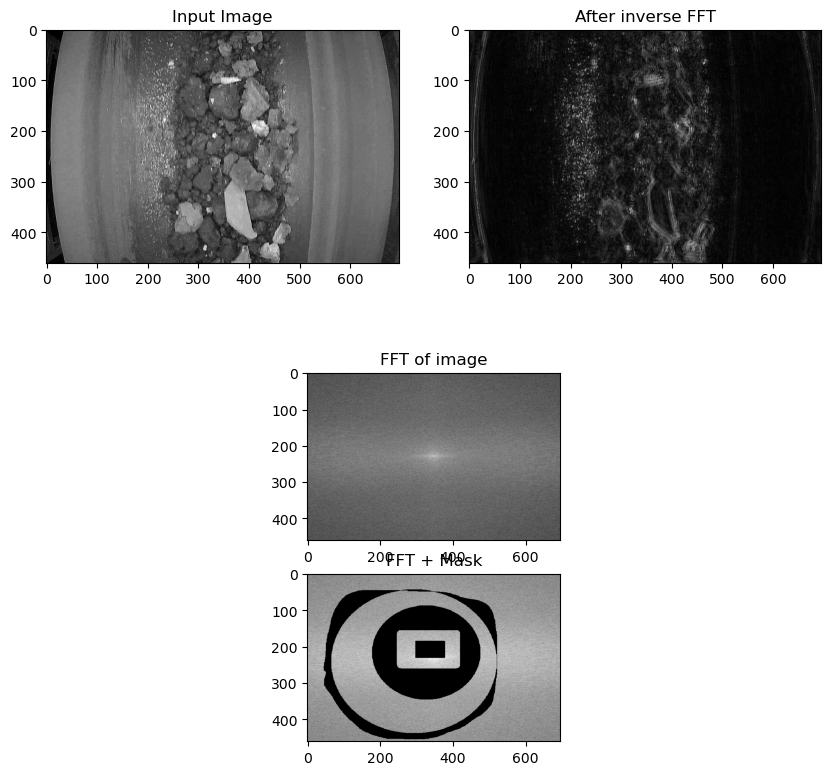

In [8]:
file = "Mining-conveyer-belt-1-300x199.png"
imge = cv2.imread(file, 0)
print("image shape", imge.shape)
_filter = custom_mask('mask-3.png', invert=False)

imge=experiment(imge, _filter)


In [9]:
# from ipywidgets import Output
# from ipycanvas import Canvas

# canvas = Canvas(width=200, height=200)
# out = Output()

# @out.capture()
# def handle_mouse_move(x, y):
#     print("Mouse move event:", x, y)

# canvas.on_mouse_move(handle_mouse_move)

# @out.capture()
# def handle_mouse_down(x, y):
#     print("Mouse down event:", x, y)

# canvas.on_mouse_down(handle_mouse_down)
# display(out)

In [10]:

#pywt.wavelist()

In [11]:
def w2d(imArray, mode='haar', level=1, display=False):
    #Datatype conversions
    #convert to grayscale
    # imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    if display:
        #Display result
        plt.figure(figsize=[10, 10])
        plt.subplot(121)
        plt.imshow(imArray, cmap="gray")
        ax =plt.subplot(122)
        ax.set_title(mode)
        plt.imshow(imArray_H, cmap="gray")
        # cv2.imshow('image',imArray_H)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.show()
    return imArray_H

In [12]:
ls

Mining-conveyer-belt-1-300x199.png      mask-2.png
belt_stone.ipynb                        mask-3.png
kaucuk-bantlar.jpeg.sb-27ea0b41-dsvW7N  small_stone.jpeg
kaucuk-bantlar.png                      stone_video.mp4
mask-1.png                              video_sample_1.jpg


In [13]:
def mat2grey(x, display=False):
    # https://en.wikipedia.org/wiki/Feature_scaling
    # Rescaling (min-max normalization)
    a, b = 0, 255
    minx, maxx = np.min(x), np.max(x)
    denormalised = a + (((x - minx)*(b - a))/(maxx - minx)).astype('uint8')
    if display:
        plt.imshow(denormalised, cmap="gray")
        plt.show()
    return denormalised

In [14]:
def contor(img, orig, area_func, 
           dilaet_conf=dict(kernel=np.ones((5,5),np.uint8), iterations=2), 
           erode_conf=dict(kernel=np.ones((5,5),np.uint8), iterations=2), 
           display=False):
    """
    Now let's try with `cv2.CHAIN_APPROX_SIMPLE`
    """
    # inverse binary threshold
    ret,img = cv2.threshold(img,70,255,cv2.THRESH_BINARY)
    if display:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    # closing
    img = cv2.dilate(img, dilaet_conf["kernel"], iterations = dilaet_conf["iterations"])
    img = cv2.erode(img, erode_conf["kernel"],iterations = erode_conf["iterations"])
    if display:
        plt.imshow(img, cmap="gray")
        plt.show()
    
    # invert image
    img = (255-img)
    if display:
        plt.imshow(img, cmap="gray")
        plt.show()    
        print("dtype:",img.dtype)
    
    # detect the contours on the binary image using cv2.ChAIN_APPROX_SIMPLE
    contours1, hierarchy1 = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    selected_contours = []
    areas = np.array([cv2.contourArea(contour) for contour in contours1])
    if display:
        print("areas max:", np.min(areas), np.median(areas), np.max(areas), np.mean(areas))
    selected_contours = [contours1[idx] for idx, area in enumerate(areas) if area_func(area)]

    # draw contours on the original image for `CHAIN_APPROX_SIMPLE`
    image_copy1 = orig.copy()

    # convert to RGB
    image_copy2 = image_copy1.copy()
    if display:
        plt.imshow(image_copy1)
        plt.show()
    # draw contrours on RGB image
    cv2.drawContours(image_copy1, contours1, -1, (255, 255, 255), 1, cv2.LINE_AA)
    if display:
        plt.imshow(image_copy1)
        plt.show()
    
    cv2.drawContours(image_copy2, selected_contours, -1, (0, 255, 0), 1, cv2.LINE_AA)
#     cv2.fillPoly(image_copy1, pts=selected_contours, color=(255,0,0,100))
    if display:
        # see the results
        plt.imshow(image_copy2)
        plt.show()
        # cv2.waitKey(0)
        # cv2.imwrite('contours_simple_image1.jpg', image_copy1)
        # cv2.destroyAllWindows()
    return image_copy2, selected_contours


In [15]:
def detect_bolbs(img_rgb, config, display=False):
    # crop:
    img_rgb = config["crop_func"](img_rgb)
    orig = img_rgb.copy() # RGB image
    # greyscale
    img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # wavelet transform
    img = w2d(img, config["wt"], config["wt_level"], display) # wavelet transform, fourier transform
    # fourier transform
    img = experiment(img, config["fft"], display)
    # convert matrix to greyscale
    img = mat2grey(img, display)
    # apply contour
    modified_orig, selected_contours = contor(img, orig, config["area_func"], 
                                              dilaet_conf=config["dilaet_conf"], 
                                              erode_conf=config["erode_conf"], display=display)
    modified_orig = cv2.cvtColor(modified_orig, cv2.COLOR_BGR2RGB)
    return modified_orig, selected_contours

image shape (640, 352, 3)


/Users/soumen/anaconda3/envs/fmri/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


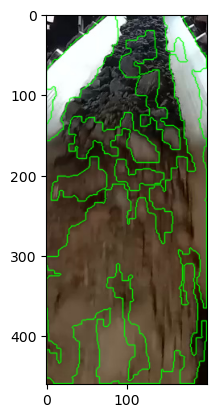

In [16]:
def crop1(im): return im[:, 40:200]
def crop2(im): return im[:, 250:450]
def crop3(im): return im[200:, :]
def crop4(im): return im[180:, 50:250]

def area_func1(x):  return 2000< x < 50000
def area_func2(x):  return 100000< x < 400000

files = [
    ("Mining-conveyer-belt-1-300x199.png",crop2,area_func1),
    ("kaucuk-bantlar.png",crop3,area_func1),
    ("small_stone.jpeg",crop1,area_func1),
    ("video_sample_1.jpg", crop4, area_func1),
]

selected =3
file, crop,  area_func = files[selected]

config_tgt = dict(wt='sym4',wt_level=5, fft=LPF, 
              dilaet_conf=dict(kernel=np.ones((3,3),np.uint8), iterations=2), 
              erode_conf=dict(kernel=np.ones((5,5),np.uint8), iterations=2), 
              crop_func=crop, area_func=area_func)

config_1 = dict(wt='sym4',wt_level=10, fft=BPF, 
              dilaet_conf=dict(kernel=np.ones((5,5),np.uint8), iterations=2), 
              erode_conf=dict(kernel=np.ones((5,5),np.uint8), iterations=2), 
              crop_func=crop, area_func=area_func)

config = [config_1, config_1, config_1, config_tgt][selected]

imge = cv2.imread(file)
orig = imge.copy()
print("image shape", imge.shape)

rgb_mod, _ = detect_bolbs(imge, config, display=False)
plt.imshow(rgb_mod)
plt.show()

In [17]:
# # haar = w2d(file,'haar',10)
# # coif10 = w2d(file,'coif10',10)
# # bior44 = w2d(file,'bior4.4',10)
# # sym4 = w2d(imge,'sym4',10) # wavelet transform, fourier transform

# # _filter = custom_mask('mask-3.png', invert=False)
# # fftimg = experiment(sym4, _filter)

# _filter = HPF # custom_mask('mask-3.png', invert=False)
# # imge = experiment(imge, _filter)
# imge = w2d(imge,'sym4',10) # wavelet transform, fourier transform
# imge,_,_ = transform(imge, _filter)



# img = imge
# # crop:
# img = crop(img)
# print(img.shape)

# # convert to greyscale
# img = mat2grey(img)

# # 
# img = contor(img, orig, area_func)

In [18]:
import cv2
vid_file = 'stone_video.mp4'
print("Reading...")
cap = cv2.VideoCapture(vid_file)
print("DONE")
while not cap.isOpened():
    cap = cv2.VideoCapture(vid_file)
    cv2.waitKey(1000)
    print ("Wait for the header")

pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
while True:
    flag, frame = cap.read()
    if flag:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        # The frame is ready and already captured
        frame, _ = detect_bolbs(frame, config_tgt)
        cv2.imshow('video', frame)
        pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        print (str(pos_frame)+" frames", end="\b\r")
    else:
        # The next frame is not ready, so we try to read it again
        cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
        print ("frame is not ready")
        # It is better to wait for a while for the next frame to be ready
        # cv2.waitKey(1000)
        # cv2.destroyAllWindows()
        exit()

    if cv2.waitKey(10) == 27:
        print('esc pressed')
        cv2.destroyAllWindows()
        exit()
        break
    if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        cv2.destroyAllWindows()
        exit()
        break

Reading...


[ WARN:0@1.649] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@1.649] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@1.649] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@1.649] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_16645483

DONE
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame is not ready
frame i